In [1]:
import cv2
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split

input_size = 128
epochs = 100
batch_size = 16
# model = get_unet_128

df_train = pd.read_csv('input/train_masks.csv')
print(type(df_train))

ids_train = df_train['img'].map(lambda s: s.split('.')[0])

ids_train_split, ids_valid_split = train_test_split(ids_train, test_size=0.2, random_state=42)

print('Training on {} samples'.format(len(ids_train_split)))
print('Validating on {} samples'.format(len(ids_valid_split)))

Using TensorFlow backend.


<class 'pandas.core.frame.DataFrame'>
Training on 4070 samples
Validating on 1018 samples


In [57]:
import os
import glob

base_path = '/atlas/home/zwpeng/kaggle/'
car_path = 'train/'
mask_path = 'train_masks/'

car_set = glob.glob(os.path.join(base_path,car_path,'*.jpg'))
mask_set = glob.glob(os.path.join(base_path,mask_path,'*.gif'))
# car_set.sort
print(len(car_set),len(mask_set),car_set[0],mask_set[0])

5088 5088 /atlas/home/zwpeng/kaggle/train/00087a6bd4dc_01.jpg /atlas/home/zwpeng/kaggle/train_masks/00087a6bd4dc_01_mask.gif


In [11]:
# 随机色调变换（颜色腐蚀）
def randomHueSaturationValue(image, hue_shift_limit=(-180, 180),
                             sat_shift_limit=(-255, 255),
                             val_shift_limit=(-255, 255), u=0.5):
    if np.random.random() < u:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(image)
        hue_shift = np.random.uniform(hue_shift_limit[0], hue_shift_limit[1])
        h = cv2.add(h, hue_shift)
        sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
        s = cv2.add(s, sat_shift)
        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = cv2.add(v, val_shift)
        image = cv2.merge((h, s, v))
        image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

    return image

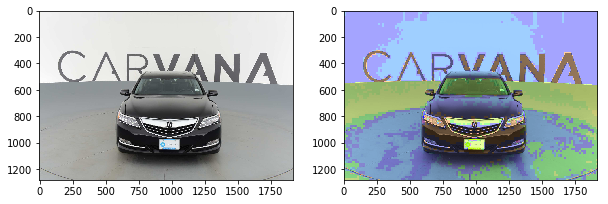

In [51]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

f,axes = plt.subplots(1,2,figsize=(10,10))
ax = axes.flatten()
ax[0].imshow(Image.open(car_set[0]))
ax[1].imshow(randomHueSaturationValue(cv2.imread(car_set[0])))

In [52]:
# 随机平移、缩放、旋转
def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0625, 0.0625),
                           scale_limit=(-0.1, 0.1),
                           rotate_limit=(-45, 45), aspect_limit=(0, 0),
                           borderMode=cv2.BORDER_CONSTANT, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape

        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])  # degree
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                    borderValue=(
                                        0, 0,
                                        0,))
        mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                   borderValue=(
                                       0, 0,
                                       0,))

    return image, mask

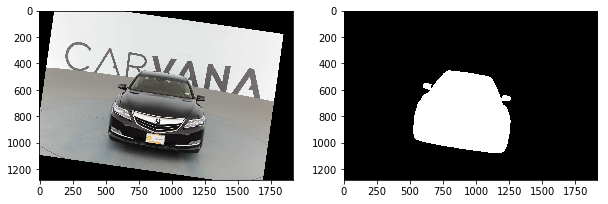

In [65]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

img_t, mask_t = randomShiftScaleRotate(cv2.imread(car_set[0]), np.array(Image.open(mask_set[0])))

f,axes = plt.subplots(1,2,figsize=(10,10))
ax = axes.flatten()
ax[0].imshow(img_t)
ax[1].imshow(mask_t,cmap='gray')


In [66]:
# 随机水平翻转
def randomHorizontalFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    return image, mask

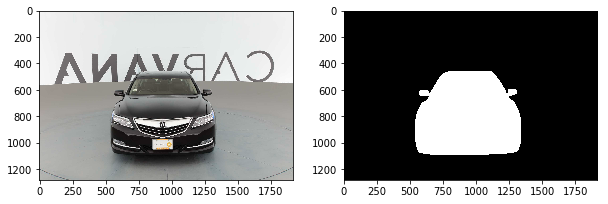

In [73]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

img_t, mask_t = randomHorizontalFlip(cv2.imread(car_set[0]), np.array(Image.open(mask_set[0])))

f,axes = plt.subplots(1,2,figsize=(10,10))
ax = axes.flatten()
ax[0].imshow(img_t)
ax[1].imshow(mask_t,cmap='gray')

In [135]:
def train_generator(input_size):
    while True:
        for start in range(0, len(ids_train_split), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(ids_train_split))
            ids_train_batch = ids_train_split[start:end]
            for i in ids_train_batch.values:
                img = cv2.imread('/atlas/home/zwpeng/kaggle/train/{}.jpg'.format(i))
                img = cv2.resize(img, (input_size, input_size))
                mask = cv2.imread('input/train_masks/{}_mask.png'.format(i), cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (input_size, input_size))
                img = randomHueSaturationValue(img,
                                               hue_shift_limit=(-50, 50),
                                               sat_shift_limit=(-5, 5),
                                               val_shift_limit=(-15, 15))
                img, mask = randomShiftScaleRotate(img, mask,
                                                   shift_limit=(-0.0625, 0.0625),
                                                   scale_limit=(-0.1, 0.1),
                                                   rotate_limit=(-10, 10))
                img, mask = randomHorizontalFlip(img, mask)
                mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.float32) / 255.
            yield x_batch, y_batch

In [136]:
exam_X, exam_y = next(train_generator(128))
print(exam_X.shape, exam_y.shape)

(16, 128, 128, 3) (16, 128, 128, 1)


In [140]:
np.mean(exam_y[0])
print(exam_y[0].shape)
a=np.squeeze(exam_y[0])
print(a.shape)

(128, 128, 1)
(128, 128)


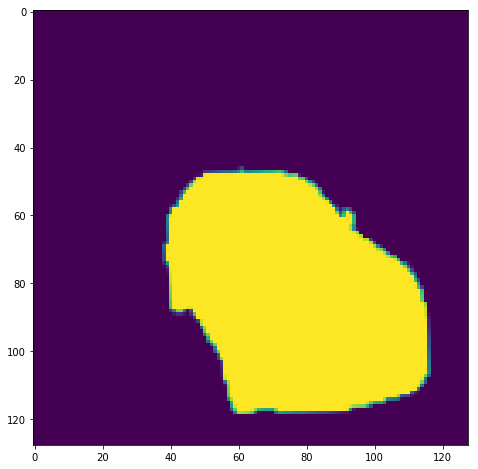

In [144]:
f,ax = plt.subplots(figsize=(8,8))
ax.imshow(a)

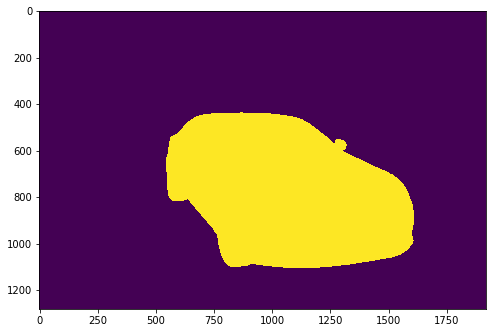

In [107]:
f,ax = plt.subplots(figsize=(8,8))
ax.imshow(cv2.imread('input/train_masks/69915dab0755_16_mask.png',cv2.IMREAD_GRAYSCALE))

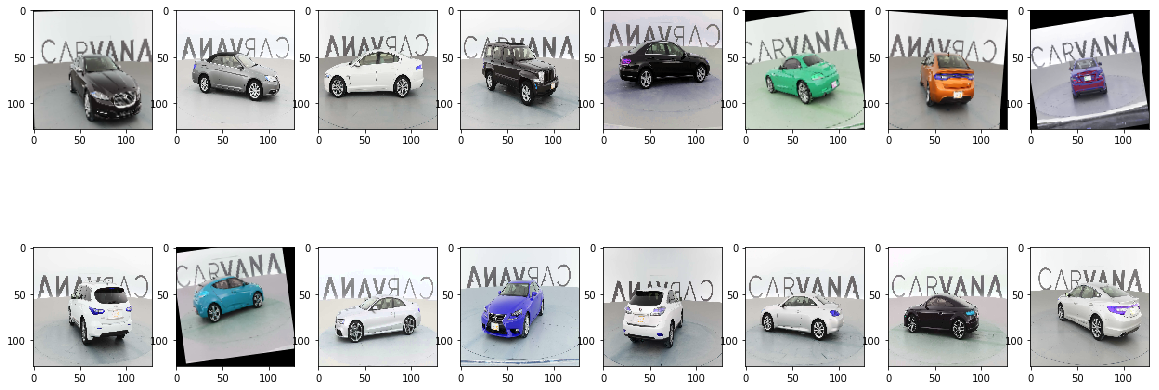

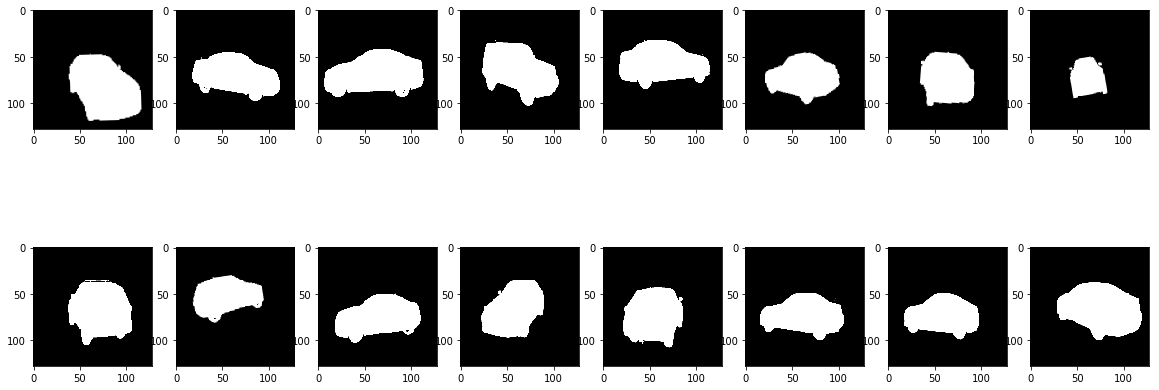

In [145]:
%matplotlib inline
import matplotlib.pyplot as plt

f,axes = plt.subplots(2,8,figsize=(20,8))
ax = axes.flatten()
for i,v in enumerate(exam_X):
    _ = ax[i].imshow(exam_X[i])

fig,axes = plt.subplots(2,8,figsize=(20,8))
ax = axes.flatten()
for i,v in enumerate(exam_y):
    _ = ax[i].imshow(np.squeeze(exam_y[i]),cmap='gray')
#     print((exam_y[i].argmax(axis=2)[50:60,80:90]))

In [78]:
import os
import glob
from PIL import Image

base_path = '/atlas/home/zwpeng/kaggle/'
gif_mask_path = 'train_masks/'
jpg_mask_path = 'unet/input/train_masks/'

gif_mask = glob.glob(os.path.join(base_path, gif_mask_path, '*.gif'))
gif_mask.sort()
print(gif_mask[0],len(gif_mask))
print(os.path.splitext(gif_mask[0])[0].split('/')[-1])
# for i,v in enumerate(gif_mask):
#     gif_mask[i].save(os.path.join(base_path, jpg_mask_path, (os.path.splitext(gif_mask[i]))[0])


/atlas/home/zwpeng/kaggle/train_masks/00087a6bd4dc_01_mask.gif 5088
00087a6bd4dc_01_mask


In [79]:
base_path = '/atlas/home/zwpeng/kaggle/'
gif_mask_path = 'train_masks/'
jpg_mask_path = 'unet/input/train_masks/'

pngImg = glob.glob(os.path.join(base_path, jpg_mask_path, '*.png'))
print(pngImg[0])

/atlas/home/zwpeng/kaggle/unet/input/train_masks/00087a6bd4dc_01_mask.png


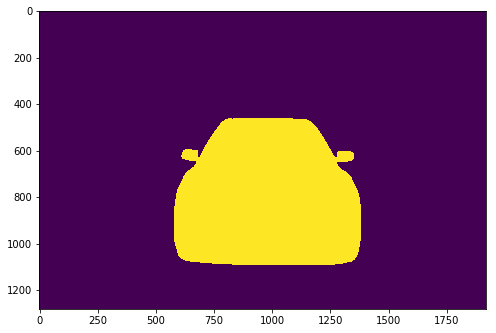

In [81]:
f,ax = plt.subplots(figsize=(8,8))
ax.imshow(cv2.imread(pngImg[0],cv2.IMREAD_GRAYSCALE))

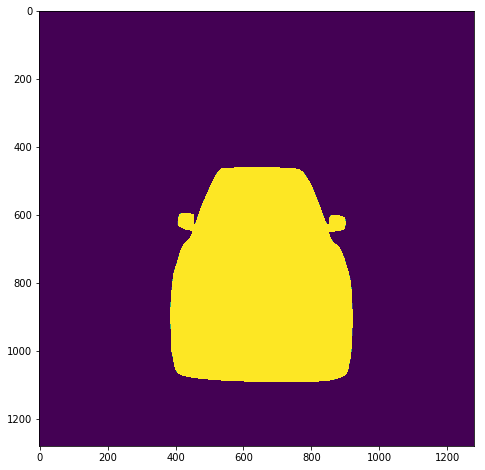

In [90]:
pngImg0 = cv2.resize(cv2.imread(pngImg[0],cv2.IMREAD_GRAYSCALE),(1280,1280))
f,ax = plt.subplots(figsize=(8,8))
ax.imshow(pngImg0)

Training on 4070 samples
Validating on 1018 samples
(16, 128, 128, 3) (16, 128, 128, 1)


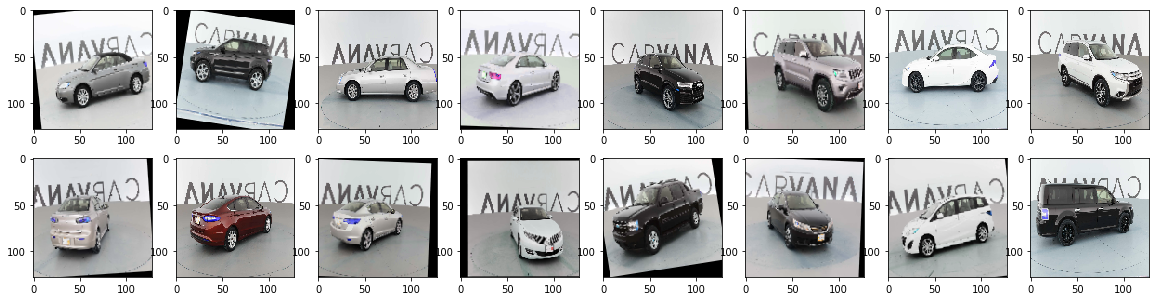

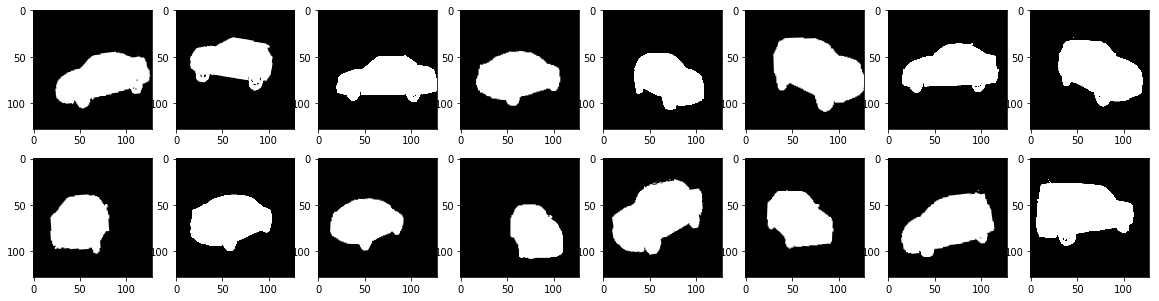

In [1]:
%matplotlib inline
from generator import plot_data
plot_data(train=True)

In [1]:
from train import train_model

train_model(128,5,16)

Using TensorFlow backend.


Training on 4070 samples
Validating on 1018 samples
Epoch 1/5
255/255 [==============================] - 261s - loss: 0.1965 - dice_coeff: 0.8843 - val_loss: 1.6835 - val_dice_coeff: 0.0644
Epoch 2/5
255/255 [==============================] - 253s - loss: 0.0825 - dice_coeff: 0.9507 - val_loss: 0.0647 - val_dice_coeff: 0.9609
Epoch 3/5
255/255 [==============================] - 249s - loss: 0.0550 - dice_coeff: 0.9686 - val_loss: 0.0398 - val_dice_coeff: 0.9770
Epoch 4/5
255/255 [==============================] - 248s - loss: 0.0428 - dice_coeff: 0.9766 - val_loss: 0.0330 - val_dice_coeff: 0.9820
Epoch 5/5
255/255 [==============================] - 248s - loss: 0.0360 - dice_coeff: 0.9808 - val_loss: 0.0271 - val_dice_coeff: 0.9853


In [1]:
import os
from glob import glob

tests = glob(os.path.join('/atlas/home/zwpeng/kaggle/', 'test/', '*.jpg'))
print(len(tests))

100064


In [2]:
from model.u_net import get_unet_128, get_unet_256, get_unet_512, get_unet_1024

model = get_unet_256()
model.load_weights('best_weights_256.h5py')

Using TensorFlow backend.


(1918, 1280)


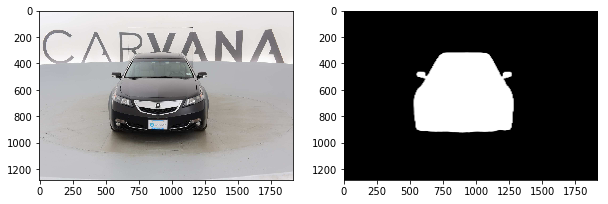

In [16]:
import cv2
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# model = load_model('m25610016.h5')
srcImg = Image.open(tests[0])
print(srcImg.size)
img_arr = (np.array(srcImg.resize((256,256)))/255.).reshape(1, 256, 256, 3)
preImg = model.predict(img_arr)
pre_img = cv2.resize(np.squeeze(preImg[0]),(1918, 1280),cv2.INTER_CUBIC)

f, axes = plt.subplots(1,2,figsize=(10,10))
ax = axes.flatten()
ax[0].imshow(srcImg)
ax[1].imshow(pre_img,cmap='gray')
# ax[1].imshow(srcImg.resize((256,256)))

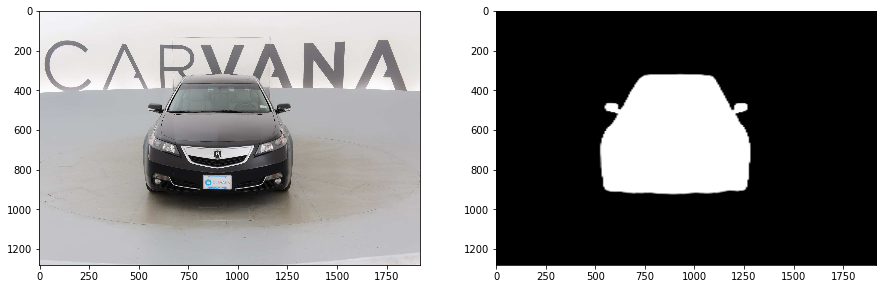

In [17]:
f, axes = plt.subplots(1,2,figsize=(15,15))
ax = axes.flatten()
ax[0].imshow(srcImg)
ax[1].imshow(pre_img,cmap='gray')